In [1]:
# code taken from https://towardsdatascience.com/lstm-time-series-forecasting-predicting-stock-prices-using-an-lstm-model-6223e9644a2f
# also taken from https://towardsdatascience.com/everything-you-need-to-know-about-min-max-normalization-in-python-b79592732b79

import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

df=pd.read_csv("TSLA.csv")
print("Number of rows and columns:", df.shape)
df.head(5)

Number of rows and columns: (1259, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
1,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
2,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
3,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000
4,2015-07-16,52.844002,53.439999,52.632000,53.335999,53.335999,8080000


In [5]:
training_set = df.iloc[:800, 1:2].values
test_set = df.iloc[800:, 1:2].values

## Min-max scaling for normalization


In [14]:
from sklearn.datasets import load_iris
# use the iris dataset
X, y = load_iris(return_X_y=True)
print(X.shape)
# (150, 4) # 150 samples (rows) with 4 features/variables (columns)
#
# build the scaler model
scaler = MinMaxScaler()

# fit using the train set
scaler.fit(X)

# transform the test test
X_scaled = scaler.transform(X)

# Verify minimum value of all features
X_scaled.min(axis=0)
# array([0., 0., 0., 0.])
#
# Verify maximum value of all features
X_scaled.max(axis=0)
# array([1., 1., 1., 1.])
#
# Manually normalise without using scikit-learn
X_manual_scaled = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

# Verify manually VS scikit-learn estimation
print(np.allclose(X_scaled, X_manual_scaled))
#True

(150, 4)
True


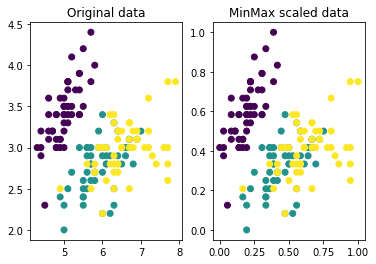

In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2)

axes[0].scatter(X[:,0], X[:,1], c=y)
axes[0].set_title("Original data")

axes[1].scatter(X_scaled[:,0], X_scaled[:,1], c=y)
axes[1].set_title("MinMax scaled data")

plt.show()

In [8]:

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 800):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(740, 60, 1)

In [9]:

model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
24/24 [==============================] - 15s 53ms/step - loss: 0.1215

In [10]:

# Getting the predicted stock price of 2017
dataset_train = df.iloc[:800, 1:2]
dataset_test = df.iloc[800:, 1:2]

dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)

inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 519):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_test.shape)
# (459, 60, 1)

(459, 60, 1)


In [11]:

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

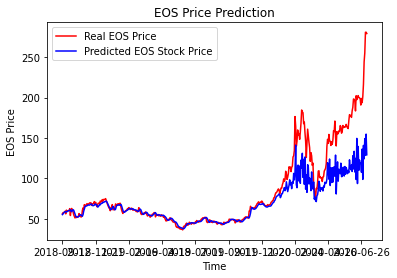

In [12]:

# Visualising the results
plt.plot(df.loc[800:,"Date"],dataset_test.values, color = 'red',
label = 'Real EOS Price')
plt.plot(df.loc[800:, "Date"],predicted_stock_price, color = 'blue',
label = 'Predicted EOS Stock Price')
plt.xticks(np.arange(0,459,50))
plt.title('EOS Price Prediction')
plt.xlabel('Time')
plt.ylabel('EOS Price')
plt.legend()
plt.show()

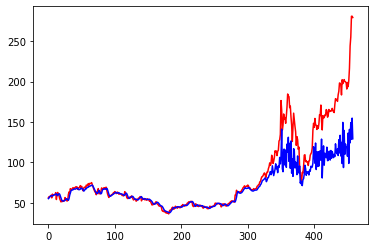

In [13]:

plt.plot(dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')
